Primeramente, en caso de no haberlo hecho antes, buildeamos el proyecto de c++ como modulos de python

In [ ]:
!sh build.sh

A continuación importamos las librerias necesarias y obtenemos la información del dataset de MNIST, dividido de tal forma que 4/5 del total se usan como entrenamiento y el 1/5 restante como validación

In [1]:
import metnum
import pandas as pd 
import numpy as np
from utils import get_MNIST
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from seaborn import heatmap
from sklearn.datasets import fetch_openml

In [2]:
#X_train, y_train, X_val, y_val = get_MNIST(0.8)

X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
y = y.astype(int)[:10000]
X = X.astype(int)[:10000]

limit = int(0.8 * X.shape[0]) 

X_train, y_train = X[:limit], y[:limit]
X_val, y_val = X[limit:], y[limit:]

assert len(X_train) == len(y_train)
assert len(X_val) == len(y_val)

print(f"Ahora tengo {len(X_train)} instancias de entrenamiento y {len(X_val)} de validación")

Ahora tengo 8000 instancias de entrenamiento y 2000 de validación


In [3]:
k = 3
alpha = 19

Separamos el dataframe en instancias de train y test y entrenamos con kNN+PCA

In [4]:
pca = metnum.PCA(alpha)
pca.fit(X_train)
X_train_PCA = pca.transform(X_train)
X_val_PCA = pca.transform(X_val)
        
clf_metnum = metnum.KNNClassifier(k)
clf_metnum.fit(X_train_PCA, y_train)
resultados = clf_metnum.predict(X_val_PCA)

Graficamos la cantidad de predicciones correctas y erroneas para cada clase con una matriz de confusión para mostrar en los casos erroneos, que clase asigno en lugar de la correcta

In [5]:
%matplotlib inline
cMatrix = confusion_matrix(y_val,resultados)

Text(33.0, 0.5, 'Predicted')

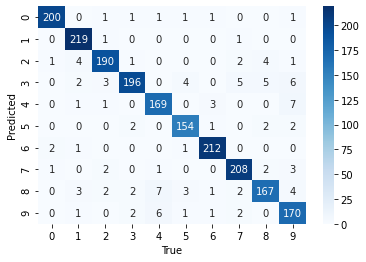

In [6]:
ax = plt.axes()
hm = heatmap(cMatrix, ax= ax, cmap="Blues", annot=True, fmt = "d")

ax.set_xlabel("True")

ax.set_ylabel("Predicted")

Calculamos los valores de precision y recall para cada clase. La precision la calculamos con la cantidad de imagenes asigandas a cierta clase de manera correcta (true positive) sobre las correctamente asignadas y las que en realidad pertenecian a otra (true positive y false positive). Luego, recall se calcula tambien con la cantidad de imagenes correctamente asigandas a cierta clase sobre las imagenes bien asignadas mas las que pertenecian a dicha clase pero fueron incorrectamente asignadas a otra (true positive y false negative)

In [7]:
precisiones = []
recalls = []
for k in range(10):
    precisiones.append(cMatrix[k][k]/(cMatrix[k].sum()))
    recalls.append(cMatrix[k][k]/(cMatrix[:,k].sum()))

Mostramos los valores de precision y recall para cada clase 

In [8]:
recalls = pd.Series(recalls)
precisiones = pd.Series(precisiones)
precision_promedio = precisiones.mean()
recall_promedio = recalls.mean()

In [9]:
result = pd.DataFrame([precisiones,recalls]).T
result.columns = ["precision", "recall"]
index = result.index
index.name = "clase"
index = [str(i) for i in range(10)]
index.append("promedio")
result

,precision,recall
clase,,
0,0.970874,0.980392
1,0.990950,0.948052
2,0.935961,0.950000
3,0.886878,0.960784
4,0.933702,0.918478
5,0.956522,0.939024
6,0.981481,0.968037
7,0.958525,0.945455
8,0.874346,0.927778


Tambien calculamos los promedio de ambas métricas y los agregamos al final de la tabla

In [11]:
promedios = pd.Series([result["precision"].mean(),result["recall"].mean()])
promedios.index = ["precision","recall"]
promedios.name = "promedio"
result = result.append(promedios)

In [12]:
result

,precision,recall
clase,,
0,0.970874,0.980392
1,0.990950,0.948052
2,0.935961,0.950000
3,0.886878,0.960784
4,0.933702,0.918478
5,0.956522,0.939024
6,0.981481,0.968037
7,0.958525,0.945455
8,0.874346,0.927778


A continuacion vamos a entrenar al modelo con un clasificador distinto llamado "Random Forest Classifier" en lugar de kNN y lo compararemos con el segundo

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

model_rfc = RandomForestClassifier()
model_rfc.fit(X_train, y_train)
rfc_preds = model_rfc.predict(X_val)
print(accuracy_score(y_val, rfc_preds))

0.9325


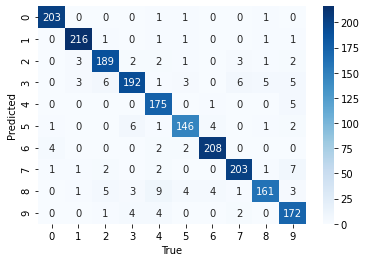

In [14]:
cMatrix_forest = confusion_matrix(y_val,rfc_preds)
heatmap(cMatrix_forest,ax= ax, cmap="Blues", annot=True, fmt = "d")
ax = plt.axes()
hm = heatmap(cMatrix_forest, ax= ax, cmap="Blues", annot=True, fmt = "d")

ax.set_xlabel("True")

ax.set_ylabel("Predicted")

def func(x, pos):
    for k in range(15):
        return "{:.2f}".format(x).replace(str(k), "")

#annotate_heatmap(hm, valfmt=matplotlib.ticker.FuncFormatter(func))


Mostramos los resultados de accuracy calculados con ambos clasificadores

In [15]:
print("kNN: ", accuracy_score(y_val, resultados), "\nRFC: ", accuracy_score(y_val, rfc_preds))

kNN:  0.9425 
RFC:  0.9325


Por último, calculamos y mostramos la métrica Kappa de Cohen del modelo entrenado con nuestra versión de kNN

In [16]:
from sklearn.metrics import cohen_kappa_score

In [17]:
cohen_kappa_score(rfc_preds,resultados)

0.9265938110241081